In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy import optimize
import os
import DSH
from DSH import Kernel
from DSH import MIfile as MI
from DSH import MIstack as MIs
from DSH import CorrMaps as CM
from DSH import IOfunctions as IOF
from DSH import SharedFunctions as SF
from DSH import ROIproc as RP

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.WARNING)
logging.info('SALS tutorial started')

INFO:root:SALS tutorial started


# RheoDLS image analysis

### 1. Open experimental data

DEBUG:root:MIfile object created with filename D:\Data\RheoSALS\240125\Oscills\period2s\009_1\imgs\000_RESTandOscills.raw
DEBUG:root:MIfile - Metadata filename automatically generated: D:\Data\RheoSALS\240125\Oscills\period2s\009_1\imgs\000_RESTandOscills_metadata.ini
DEBUG:root:Now loading MIfile metadata (from filename: D:\Data\RheoSALS\240125\Oscills\period2s\009_1\imgs\000_RESTandOscills_metadata.ini)
DEBUG:root:Loading config file D:\Data\RheoSALS\240125\Oscills\period2s\009_1\imgs\000_RESTandOscills_metadata.ini (1 sections, 6 keys)
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfile']


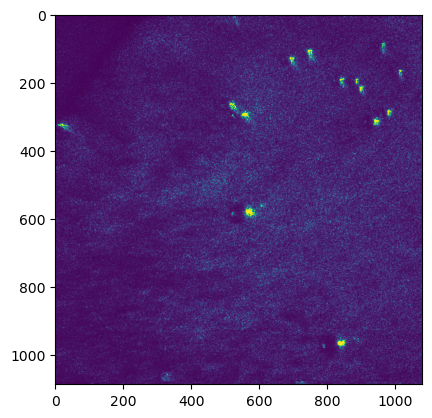

In [2]:
#---------------------------------
froot = r'D:\Data\RheoSALS\240125\Oscills\period2s\009_1\imgs'
fname_prefix = '000_RESTandOscills'
#fname_prefix = '001_OscillSState'
#---------------------------------

imgTimes, imgTimes_hdr = IOF.LoadResFile(os.path.join(froot, fname_prefix+'_imgTimes.dat'), readHeader=True, isolateFirst=0, delimiter='\t', comments='#', missing_values='-')

MIinput = MI.MIfile(os.path.join(froot, fname_prefix+'.raw'))
MIinput.OpenForReading()
plt.imshow(MIinput.GetImage(0))

### 2. Visualize stress and strain from NI DAQ

Sample parameters (calibrated upon loading): Gap=0.700mm; Cross-section area=3.000cm2
2000 stress-strain datapoints read during the acquisition of 2000 images


Text(0, 0.5, '$\\sigma$ [Pa]')

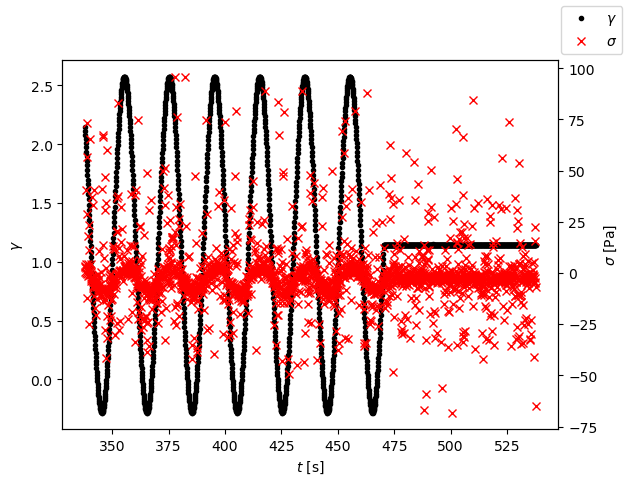

In [3]:
#---------------------------------
Gap = 0.7
Area = 3.0
ForceConversion = 2.2/15 # <-- this means that 2.2 force produces 15V signal in the DAQ (this is the conversion factor on 07/07/2023)
#---------------------------------

print('Sample parameters (calibrated upon loading): Gap={0:.3f}mm; Cross-section area={1:.3f}cm2'.format(Gap, Area))

nan_mask = np.logical_or(np.isnan(imgTimes[:,9]), np.isnan(imgTimes[:,10]))
Rheo_times = imgTimes[~nan_mask,11]
Strain = imgTimes[~nan_mask,9] / Gap
Stress = imgTimes[~nan_mask,10] * ForceConversion / (Area * 1e-4)

print('{0} stress-strain datapoints read during the acquisition of {1} images'.format(len(Rheo_times), len(imgTimes[:,9])))

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(Rheo_times, Strain, 'k.', label=r'$\gamma$')
ax2.plot(Rheo_times, Stress, 'rx', label=r'$\sigma$')
fig.legend()
ax.set_xlabel(r'$t$ [s]')
ax.set_ylabel(r'$\gamma$')
ax2.set_ylabel(r'$\sigma$ [Pa]')

### 3. Initialize ROIproc object

DEBUG:root:3 binary masks created with shape (400, 600)
INFO:root:Set 3 valid ROIs
DEBUG:root:9999 image times loaded (Image number: 9999)
DEBUG:root:Set one single exposure time: 1



|-----------------|
|  ROIproc class: |
|-----------------+---------------
| Input           : MIfile (D:\Data\RheoSALS\240117\SUFs\1.000\imgs\000_RESTandStartup.raw), 9999 images
| ROIs            : 3 (3 valid, 0 empty)
| Exposure times  : 1, from 1 to 1
|-----------------+---------------


(315.0, 0.0)

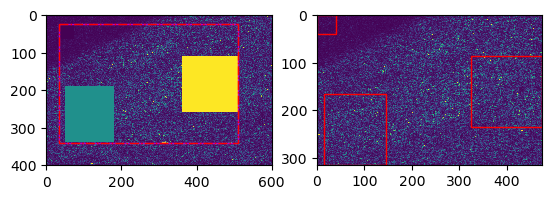

In [3]:
#---------------------------------
ROI_coords = [[55, 45, 40, 40], [115, 265, 130, 150], [435, 185, 150, 150]] # <-- [affine_ROI, nonaffine_ROI] each ROI is defined as [x_center, y_center, width, height]
#---------------------------------

pixel_coords = SF.PixelCoordGrid(MIinput.ImageShape(), extent=None, center=[0, 0], angle=0, coords='cartesian', indexing='xy')
ROIs = RP.GenerateMasks(ROI_coords, pixel_coords, common_mask=None)
ROI_proc = RP.ROIproc(MIinput, ROIs, imgTimes=imgTimes[:,3])
ROIbb = ROI_proc.BoundingBox
ROIbb2 = ROI_proc.CropROIbb
im1_crop = ROI_proc.GetImage(0)

print(ROI_proc)

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(MIinput.GetImage(0), interpolation='none', extent=(0, ROI_proc.ROIs.shape[1], ROI_proc.ROIs.shape[0], 0))
ax[0].imshow(np.where(ROI_proc.ROIs<0, np.nan, ROI_proc.ROIs), interpolation='none', extent=(0, ROI_proc.ROIs.shape[1], ROI_proc.ROIs.shape[0], 0))
ax[0].add_patch(patches.Rectangle((ROIbb[1], ROIbb[0]), ROIbb[3]-ROIbb[1], ROIbb[2]-ROIbb[0], edgecolor='m', facecolor='none'))
ax[0].add_patch(patches.Rectangle((ROIbb2[0], ROIbb2[1]), ROIbb2[2], ROIbb2[3], ls='-.', edgecolor='r', facecolor='none'))
ax[1].imshow(im1_crop, interpolation='none', extent=(0, ROI_proc.CropROIbb[2], ROI_proc.CropROIbb[3], 0))
for ridx in range(len(ROI_proc.ROIboundingBoxes)):
    _rbb = ROI_proc.ROIboundingBoxes[ridx]
    if ROI_proc.ROI_masks_crop is not None:
        ax[1].imshow(ROI_proc.ROI_masks_crop[ridx], interpolation='none', extent=(_rbb[1], _rbb[3], _rbb[2], _rbb[0]), vmin=0, vmax=1)
    ax[1].add_patch(patches.Rectangle((_rbb[1], _rbb[0]), _rbb[3]-_rbb[1], _rbb[2]-_rbb[0], edgecolor='r', facecolor='none'))
ax[1].set_xlim([0, ROI_proc.CropROIbb[2]])
ax[1].set_ylim([ROI_proc.CropROIbb[3], 0])

### 4. SLS/DLS analysis

First, estimate the processing time with a limited number of time delays

In [6]:
%%time
ROI_proc.doDLS(os.path.join(froot, fname_prefix+'_out'), lagtimes=list(range(2000)))

INFO:root:ROIproc.doDLS Analysis started! Input data is 2000 images (2000 times, 1 exposure times)
INFO:root:Analysis will resolve 3 ROIs and DLS will be performed on 2000 reference times and 2000 lagtimes. Output will be saved in folder C:\Temp\240125\Oscills\period20s\012\imgs\001_OscillSState_out
INFO:root:Now starting with SLS...


Created folder: C:\Temp\240125\Oscills\period20s\012\imgs\001_OscillSState_out


Based on this, set the number of time delays that can be computed. To log-space $N$ integer time delays, $\tau_i$, ensuring that $\tau_{i+1}$ is strictly larger than $\tau_i$, use:

```python
SF.IntLogSpace(num_points, ppd='auto', first_point=1, autoppd_maxval=None)
```

where:

- ```num_points``` is the number of time delays
- ```ppd``` is the number of points per decade. If set to ```'auto'```, it will be automatically calculated to the closest integer such that the maximum delay is smaller than a given $\tau_{Max}$, set by ```autoppd_maxval```. This optimization is done by the function ```SF.IntLogSpace_GetBestPPD(num_points, max_value, first_point=1)```.
- ```first_point``` is the first point of the series (non-zero)

In [7]:
auto_lags = SF.IntLogSpace(300, ppd='auto', autoppd_maxval=ROI_proc.ImageNumber())
print('{0} time delays log-spaced between 1 and {1}: [{2}, {3}, ..., {4}, {5}]'.format(len(auto_lags), ROI_proc.ImageNumber(), auto_lags[0], auto_lags[1], auto_lags[-2], auto_lags[-1]))

300 time delays log-spaced between 1 and 3000: [1, 2, ..., 2918, 2997]


In [10]:
%%time
ROI_proc.doDLS(os.path.join(froot, 'out'), lagtimes=auto_lags, g2m1_averageN=100)

INFO:root:ROIproc.doDLS Analysis started! Input data is 9999 images (9999 times, 1 exposure times)
INFO:root:Analysis will resolve 2 ROIs and DLS will be performed on 9999 reference times and 1001 lagtimes. Output will be saved in folder D:\Chiara\230706\SUF_relax\0.500\imgs\out
INFO:root:Now starting with SLS...


1000 time delays log-spaced between 1 and 9999: [1, 2, ..., 9908]


DEBUG:root:ROIproc.doSLS: output saved
DEBUG:root:ROIproc.doSLS analysis returned: raw data (shape: (9999, 1, 2)), Iavg data (shape: (9999, 2)), exptime data (shape: (9999, 2)), buffer images (shape (9999, 225, 255))
INFO:root:SLS analysis completed. Now doing DLS (1 exposure times, 9999 time points, 1001 lagtimes)
INFO:root:Now performing DLS on 0-th exposure time. Using image range [0, 9999, 1] (9999 images)
INFO:root:Contrast (d0) processed
INFO:root:Lagtime 1/1000 (d1) completed
INFO:root:Lagtime 2/1000 (d2) completed
INFO:root:Lagtime 3/1000 (d3) completed
INFO:root:Lagtime 4/1000 (d4) completed
INFO:root:Lagtime 5/1000 (d5) completed
INFO:root:Lagtime 6/1000 (d6) completed
INFO:root:Lagtime 7/1000 (d7) completed
INFO:root:Lagtime 8/1000 (d8) completed
INFO:root:Lagtime 9/1000 (d9) completed
INFO:root:Lagtime 10/1000 (d10) completed
INFO:root:Lagtime 11/1000 (d11) completed
INFO:root:Lagtime 12/1000 (d12) completed
INFO:root:Lagtime 13/1000 (d13) completed
INFO:root:Lagtime 14/100

CPU times: total: 1h 4min 17s
Wall time: 1h 4min 16s


### 5. Visualizing analysis output

DEBUG:root:DSH.IOfunctions.OpenG2M1s: 2 g2-1 functions loaded from 2 ROIs found in folder D:\Chiara\230706\SUF_relax\0.500\imgs\out


Text(0, 0.5, '$g_2-1$')

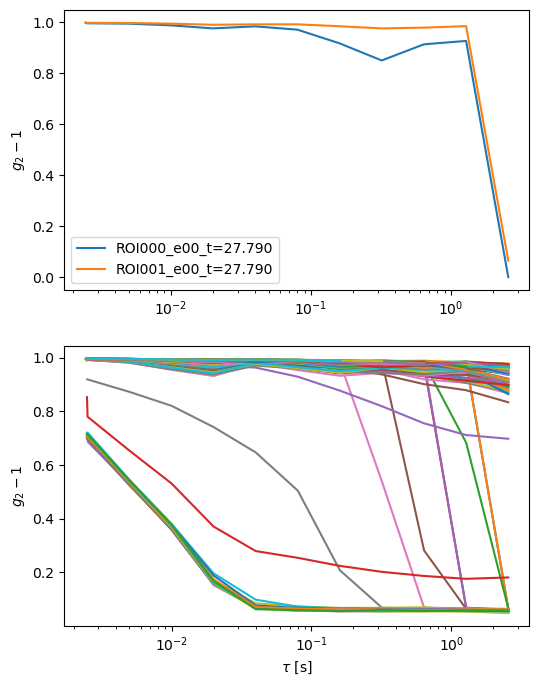

In [9]:
g2m1_data, lagtimes, imgtimes, ROI_list, exptime_list = IOF.OpenG2M1s(os.path.join(froot, 'out'))
fig, ax = plt.subplots(nrows=2, figsize=(6, 8))
tidx=0
for i in range(len(g2m1_data)):
    ax[0].plot(lagtimes[i][tidx][1:], g2m1_data[i][tidx][1:], label='ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2)+'_t={0:.3f}'.format(imgtimes[i][tidx]))
ax[0].set_xscale('log')
ax[0].legend()
ridx=-1
for i in range(len(g2m1_data[ridx])):
    ax[1].plot(lagtimes[ridx][i][1:], g2m1_data[ridx][i][1:], label='ROI'+str(ROI_list[ridx]).zfill(3)+'_e'+str(exptime_list[ridx]).zfill(2)+'_t={0:.3f}'.format(imgtimes[ridx][i]))
ax[1].set_xscale('log')
#ax[1].legend()
ax[1].set_xlabel(r'$\tau$ [s]')
ax[0].set_ylabel(r'$g_2-1$')
ax[1].set_ylabel(r'$g_2-1$')

### 6: Run in series

In [7]:
base_dir = r'D:\Data\RheoSALS\240117\SUFs'
anal_basedir = r'D:\Chiara\240117\SUFs\analOut'
subolders_list = [ '0.750', '0.500', '0.300', '0.200', '0.100', '0.075']
for cursf in subolders_list:
    cur_folder = os.path.join(base_dir, cursf, 'imgs')
    cur_outfolder = os.path.join(anal_basedir, cursf)
    logging.debug('Working folder: ' + str(cur_folder) + ' -- Output folder: ' + str(cur_outfolder))
    flist = SF.FindFileNames(cur_folder, Prefix='0', Ext='.raw')
    for curf in flist:
        cur_prefix = curf[:-4]
        logging.debug('Now processing file ' + str(cur_prefix) + '...')
        
        imgTimes, imgTimes_hdr = IOF.LoadResFile(os.path.join(cur_folder, cur_prefix+'_imgTimes.dat'), readHeader=True, isolateFirst=0, delimiter='\t', comments='#', missing_values='-')
        MIinput = MI.MIfile(os.path.join(froot, fname_prefix+'.raw'))
        MIinput.OpenForReading()
        
        pixel_coords = SF.PixelCoordGrid(MIinput.ImageShape(), extent=None, center=[0, 0], angle=0, coords='cartesian', indexing='xy')
        ROIs = RP.GenerateMasks(ROI_coords, pixel_coords, common_mask=None)
        ROI_proc = RP.ROIproc(MIinput, ROIs, imgTimes=imgTimes[:,3])
         
        auto_lags = SF.IntLogSpace(1000, ppd='auto', autoppd_maxval=ROI_proc.ImageNumber())
        ROI_proc.doDLS(os.path.join(cur_outfolder, cur_prefix), lagtimes=auto_lags, g2m1_averageN=100)
        
        ROI_proc, imgTimes, auto_lags = None, None, None

       

DEBUG:root:Working folder: D:\Data\RheoSALS\240117\SUFs\0.750\imgs -- Output folder: D:\Chiara\240117\SUFs\analOut\0.750
DEBUG:root:Now processing file 000_RESTandStartup...
DEBUG:root:MIfile object created with filename D:\Data\RheoSALS\240117\SUFs\1.000\imgs\000_RESTandStartup.raw
DEBUG:root:MIfile - Metadata filename automatically generated: D:\Data\RheoSALS\240117\SUFs\1.000\imgs\000_RESTandStartup_metadata.ini
DEBUG:root:Now loading MIfile metadata (from filename: D:\Data\RheoSALS\240117\SUFs\1.000\imgs\000_RESTandStartup_metadata.ini)
DEBUG:root:Loading config file D:\Data\RheoSALS\240117\SUFs\1.000\imgs\000_RESTandStartup_metadata.ini (1 sections, 6 keys)
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfile']
DEBUG:root:3 binary masks created with shape (400, 600)
INFO:root:Set 3 valid ROIs
DEBUG:root:9999 image times loaded (Image number: 9999)
DEBUG:root:Set one single exposure time: 1


Created folder: D:\Chiara\240117\SUFs\analOut\0.750\000_RESTandStartup


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Correlation maps

Step 1: choose the kernel

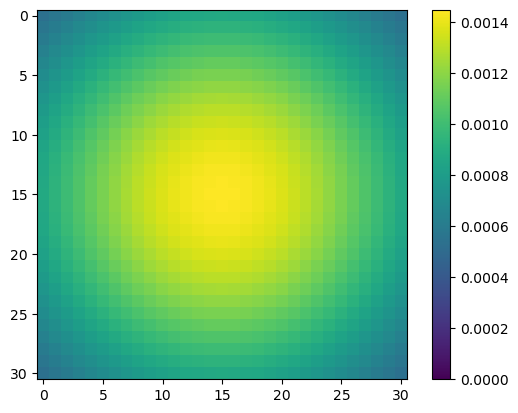

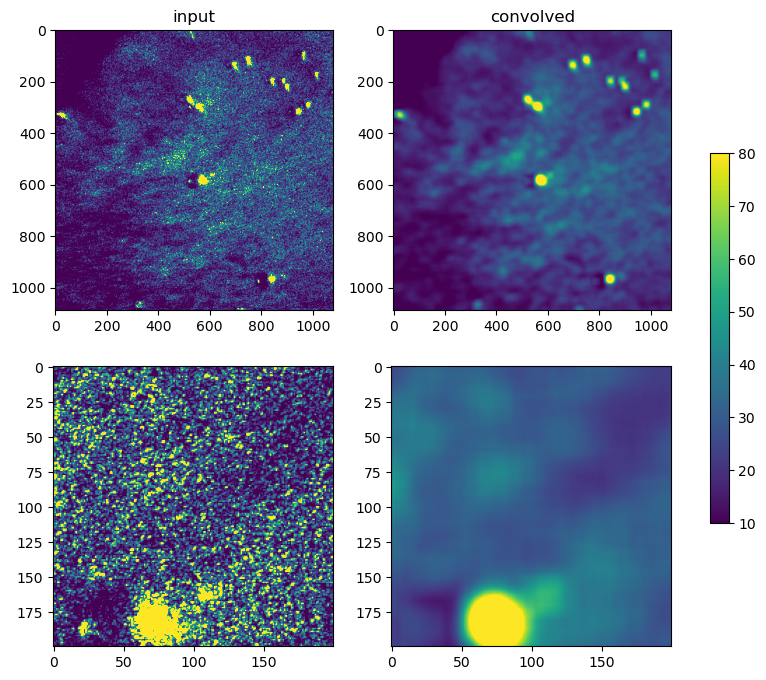

In [3]:
imTest = MIinput.GetImage(0)
KernelSpecs = Kernel.Kernel()
KernelSpecs.Initialize(shape=31, kernel_type='Gauss', params={'sigma':15}, padding=True)
imConvolved = KernelSpecs.ConvolveImage(imTest)
mROI = [400, 600, 500, 700]
vRange = [10, 80]

plt.imshow(KernelSpecs.ToMatrix(), vmin=0)
plt.colorbar()

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0,0].set_title('input')
ax[0,0].imshow(imTest, vmin=vRange[0], vmax=vRange[1])
ax[0,1].set_title('convolved')
cbar = ax[0,1].imshow(imConvolved, vmin=vRange[0], vmax=vRange[1])
ax[1,0].imshow(imTest[mROI[0]:mROI[1], mROI[2]:mROI[3]], vmin=vRange[0], vmax=vRange[1])
ax[1,1].imshow(imConvolved[mROI[0]:mROI[1], mROI[2]:mROI[3]], vmin=vRange[0], vmax=vRange[1])
fig.colorbar(cbar, ax=ax, shrink=0.6)

Step 2: choose time windows (oscillation start + steady state)

In [4]:
cI_fname = os.path.join(froot, fname_prefix+'_out', 'cI_ROI001_e00.dat')
with open(cI_fname) as f:
    header = f.readline()[1:]
hdr_list = header.strip().split('\t')

first_colN = 10
delay_period = 40

period_lbl = 'd' + str(delay_period)
Tindex = hdr_list.index(period_lbl)
echo_cols = [i for i in range(Tindex, len(hdr_list), delay_period)]

print('First {0} columns: {1}'.format(first_colN, hdr_list[:first_colN]))
print('Index of oscillation period "{0}": {1}'.format(period_lbl, Tindex))
print('All multiples of oscillation period: {0}'.format(hdr_list[Tindex::delay_period]))
print('Corresponding columns: {0}'.format(echo_cols))

First 10 columns: ['idx', 't', 'd0_raw', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7']
Index of oscillation period "d40": 42
All multiples of oscillation period: ['d40', 'd80', 'd120', 'd160', 'd200', 'd240', 'd280', 'd320', 'd360', 'd400', 'd440', 'd480', 'd520', 'd560', 'd600', 'd640', 'd680', 'd720', 'd760', 'd800', 'd840', 'd880', 'd920', 'd960', 'd1000', 'd1040', 'd1080', 'd1120', 'd1160', 'd1200', 'd1240', 'd1280', 'd1320', 'd1360', 'd1400', 'd1440', 'd1480', 'd1520', 'd1560', 'd1600', 'd1640', 'd1680', 'd1720', 'd1760', 'd1800', 'd1840', 'd1880', 'd1920', 'd1960', 'd2000', 'd2040', 'd2080', 'd2120', 'd2160', 'd2200', 'd2240', 'd2280', 'd2320', 'd2360', 'd2400', 'd2440', 'd2480', 'd2520', 'd2560', 'd2600', 'd2640', 'd2680', 'd2720', 'd2760', 'd2800', 'd2840', 'd2880', 'd2920', 'd2960', 'd3000', 'd3040', 'd3080', 'd3120', 'd3160', 'd3200', 'd3240', 'd3280', 'd3320', 'd3360', 'd3400', 'd3440', 'd3480', 'd3520', 'd3560', 'd3600', 'd3640', 'd3680', 'd3720', 'd3760', 'd3800', 'd3840', 'd3

oscillations started at t=30.004s (593-th datapoint)


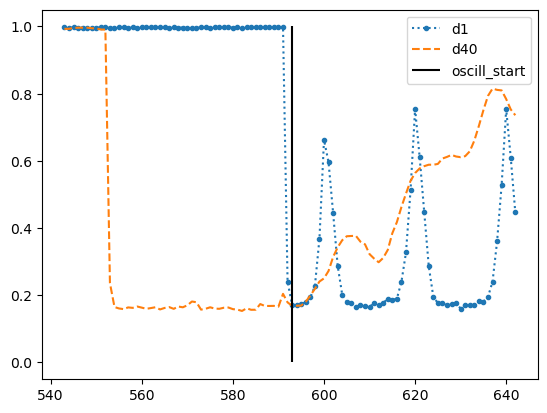

In [5]:
echo_data = np.loadtxt(cI_fname, usecols=[0, 1, 3]+echo_cols)
threshold_corr = 0.95
for i in range(echo_data.shape[0]):
    if echo_data[i,2] < threshold_corr:
        start_idx = i+1
        break

print('oscillations started at t={0:.3f}s ({1}-th datapoint)'.format(echo_data[start_idx,1], int(echo_data[start_idx,0])))

margin = 50
plt.plot(echo_data[start_idx-margin:start_idx+margin,0], echo_data[start_idx-margin:start_idx+margin,2], '.:', label='d1')
plt.plot(echo_data[start_idx-margin:start_idx+margin,0], echo_data[start_idx-margin:start_idx+margin,3], '--', label=period_lbl)
plt.vlines(start_idx, 0, 1, colors='k', label='oscill_start')
plt.legend()

First 10 oscillations: time range [30.004-50.004]s, image range [593-993]
Steady-state 10 oscillations: time range [80.004-100.004]s, image range [1593-1993]


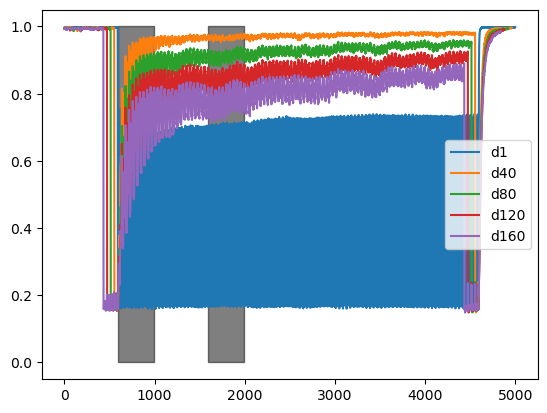

In [6]:
N_periods_calc = 10
Transient_len = 1000
cmap_calc_everyN = 1

tRange_start = [start_idx, start_idx+delay_period*N_periods_calc, cmap_calc_everyN]
tRange_steady = [start_idx+Transient_len, start_idx+Transient_len+delay_period*N_periods_calc, cmap_calc_everyN]

print('First {0} oscillations: time range [{1:.3f}-{2:.3f}]s, image range [{3}-{4}]'.format(N_periods_calc, echo_data[tRange_start[0],1], echo_data[tRange_start[1],1], int(echo_data[tRange_start[0],0]), int(echo_data[tRange_start[1],0])))
print('Steady-state {0} oscillations: time range [{1:.3f}-{2:.3f}]s, image range [{3}-{4}]'.format(N_periods_calc, echo_data[tRange_steady[0],1], echo_data[tRange_steady[1],1], int(echo_data[tRange_steady[0],0]), int(echo_data[tRange_steady[1],0])))

fig, ax = plt.subplots()
ax.fill_betweenx([0, 1], [tRange_start[0]]*2, [tRange_start[1]]*2, color= 'k', alpha=0.5)
ax.fill_betweenx([0, 1], [tRange_steady[0]]*2, [tRange_steady[1]]*2, color= 'k', alpha=0.5)
ax.plot(echo_data[:,0], echo_data[:,2], label='d1')
for idx in [1, 2, 3, 4]:
    ax.plot(echo_data[:,0], echo_data[:,2+idx], label=hdr_list[echo_cols[idx-1]])
ax.legend()

Step 3: choose time delays (intracycle $c=0.5$, first echo, echo at $c=0.5$):

In [8]:
nperiods_first = 4
first_data = np.loadtxt(cI_fname, usecols=[0, 1]+[3+i for i in range(delay_period*nperiods_first)])

echo_data_mean = np.nanmean(echo_data[tRange_steady[0]:tRange_steady[1]], axis=0)
first_data_mean = np.nanmean(first_data[tRange_steady[0]:tRange_steady[1]], axis=0)

C:\Users\stefa\AppData\Local\Temp\ipykernel_20104\1342358765.py:4: RuntimeWarning: Mean of empty slice
  echo_data_mean = np.nanmean(echo_data[tRange_steady[0]:tRange_steady[1]], axis=0)


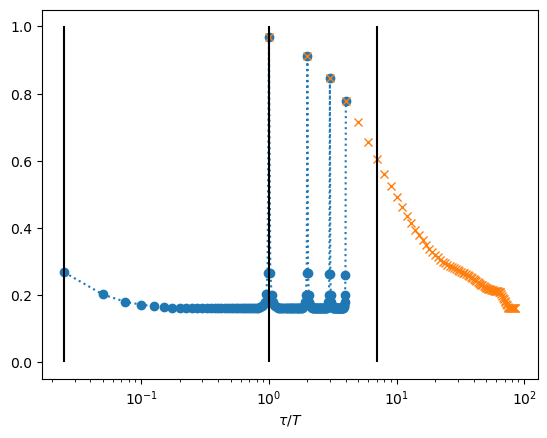

In [9]:
lagtimes_calc = [1, delay_period, 7*delay_period]

fig, ax = plt.subplots()
ax.plot(np.linspace(1.0/delay_period, nperiods_first, delay_period*nperiods_first), first_data_mean[2:], 'o:')
ax.plot(list(range(1, len(echo_cols)+1)), echo_data_mean[3:], 'x')
ax.set_xscale('log')
ax.set_xlabel(r'$\tau/T$')
ax.vlines(np.asarray(lagtimes_calc)/delay_period, [0]*len(lagtimes_calc), [1]*len(lagtimes_calc), colors='k')

Step 4: compute correlation maps

In [11]:
corrmap = CM.CorrMaps(MIinput, os.path.join(froot, fname_prefix+'_out', 'cmaps_steady'), lagtimes_calc, KernelSpecs, imgRange=None, cropROI=None)
print(corrmap)


|-----------------|
| CorrMaps class: |
|-----------------+---------------
| MI input        : <MIfile: 0+5000x1088x1080x1 bytes>
| output folder   : D:\Data\RheoSALS\240125\Oscills\period2s\009_1\imgs\000_RESTandOscills_out\cmaps_steady
| lag times (03)  : [1, 40, 280]
| image range     : [0, 5000, 1]
| crop ROI        : None
| Kernel          : <Kernel [2D Gauss], 31x31, s=(15;15), pad>
|-----------------+---------------


In [12]:
tRange_steady

[1593, 1993, 1]

In [13]:
corrmap.Compute(silent=False, save_tRange=tRange_steady, save_autocorr=False, trim_endNaNs=True) # tRange_start

Computing correlation maps:
  STEP 1: Loading images and computing average intensity...


DEBUG:root:MIfile closed reading file handle


  STEP 2: Computing contrast...


DEBUG:root:MIfile object created with filename D:\Data\RheoSALS\240125\Oscills\period2s\009_1\imgs\000_RESTandOscills_out\cmaps_steady\CorrMap_d0001.dat
DEBUG:root:Now loading MIfile metadata (dict with 5 keys)
DEBUG:root:Appending input dictionary to section MIfile
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfile', 'settings']


  STEP 3: Computing correlations...
     ...lag 1 will have shape (400, 1088, 1080)


DEBUG:root:MIfile D:\Data\RheoSALS\240125\Oscills\period2s\009_1\imgs\000_RESTandOscills_out\cmaps_steady\CorrMap_d0001.dat opened for writing
INFO:root:MIfile.WriteData: writing large array (470016000 elements) in bunches of 100000000
DEBUG:root:MIfile.WriteData: x-sections 0-100000000 out of 470016000 written to file
DEBUG:root:MIfile.WriteData: x-sections 100000000-200000000 out of 470016000 written to file
DEBUG:root:MIfile.WriteData: x-sections 200000000-300000000 out of 470016000 written to file
DEBUG:root:MIfile.WriteData: x-sections 300000000-400000000 out of 470016000 written to file
DEBUG:root:MIfile.WriteData: x-sections 400000000-470016000 out of 470016000 written to file
DEBUG:root:ndarray of shape (400, 1088, 1080) successfully written to MIfile D:\Data\RheoSALS\240125\Oscills\period2s\009_1\imgs\000_RESTandOscills_out\cmaps_steady\CorrMap_d0001.dat
DEBUG:root:MIfile closed writing file handle
DEBUG:root:MIfile D:\Data\RheoSALS\240125\Oscills\period2s\009_1\imgs\000_RESTa

     ...lag 40 will have shape (400, 1088, 1080)


DEBUG:root:MIfile.WriteData: x-sections 0-100000000 out of 470016000 written to file
DEBUG:root:MIfile.WriteData: x-sections 100000000-200000000 out of 470016000 written to file
DEBUG:root:MIfile.WriteData: x-sections 200000000-300000000 out of 470016000 written to file
DEBUG:root:MIfile.WriteData: x-sections 300000000-400000000 out of 470016000 written to file
DEBUG:root:MIfile.WriteData: x-sections 400000000-470016000 out of 470016000 written to file
DEBUG:root:ndarray of shape (400, 1088, 1080) successfully written to MIfile D:\Data\RheoSALS\240125\Oscills\period2s\009_1\imgs\000_RESTandOscills_out\cmaps_steady\CorrMap_d0040.dat
DEBUG:root:MIfile closed writing file handle
DEBUG:root:MIfile D:\Data\RheoSALS\240125\Oscills\period2s\009_1\imgs\000_RESTandOscills_out\cmaps_steady\CorrMap_d0040.dat closing after writing
DEBUG:root:MIfile object created with filename D:\Data\RheoSALS\240125\Oscills\period2s\009_1\imgs\000_RESTandOscills_out\cmaps_steady\CorrMap_d0280.dat
DEBUG:root:Now l

     ...lag 280 will have shape (400, 1088, 1080)


DEBUG:root:MIfile.WriteData: x-sections 0-100000000 out of 470016000 written to file
DEBUG:root:MIfile.WriteData: x-sections 100000000-200000000 out of 470016000 written to file
DEBUG:root:MIfile.WriteData: x-sections 200000000-300000000 out of 470016000 written to file
DEBUG:root:MIfile.WriteData: x-sections 300000000-400000000 out of 470016000 written to file
DEBUG:root:MIfile.WriteData: x-sections 400000000-470016000 out of 470016000 written to file
DEBUG:root:ndarray of shape (400, 1088, 1080) successfully written to MIfile D:\Data\RheoSALS\240125\Oscills\period2s\009_1\imgs\000_RESTandOscills_out\cmaps_steady\CorrMap_d0280.dat
DEBUG:root:MIfile closed writing file handle
DEBUG:root:MIfile D:\Data\RheoSALS\240125\Oscills\period2s\009_1\imgs\000_RESTandOscills_out\cmaps_steady\CorrMap_d0280.dat closing after writing


Procedure completed in 21809.4 seconds!
